In [19]:
# 필요한 라이브러리 import

import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw

from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME') + '/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR + '/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR + '/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR + '/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


In [20]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


# 데이터셋

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


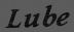

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


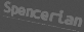

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


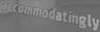

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


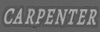

In [4]:
# 데이터셋 안에 이미지 상태 확인
# lmdb를 통해 훈련데이터셋의 이미지를 4개만 열어서 실제 shape와 image, label을 확인.
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH,
               max_readers=32,
               readonly=True,
               lock=False,
               readahead=False,
               meminit=False)

# 불러온 데이터를 txn(transaction) 이라는 변수를 통해서 엽니다.
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요.
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면 
        # txn에서 라벨과 이미지를 읽어올 수 있어요.
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode("utf-8")
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        
        # 이미지는 버퍼를 통해 읽어오기 때문에
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert("RGB")
        
        except IOError:
            img = Image.new("RGB", (100, 32))
            label = "-"
            
        # 원본 이미지 크기를 출력해 봅니다.
        width, height = img.size
        print("original image width:{}, height:{}".format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다 작게하고 싶어요
        target_width = min(int(width * 32 / height), 100)
        target_img_size = (target_width, 32)
        print("target_img_size:{}".format(target_img_size))
        img = np.array(img.resize(target_img_size)).transpose(1, 0, 2)
        
        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요
        print("display img shape:{}".format(img.shape))
        print("label:{}".format(label))
        display(Image.fromarray(img.transpose(1, 0, 2).astype(np.uint8)))

* 이미지들의 width는 각각 다르지만, height는 31로 같습니다.

* lmdb를 활용하여 케라스 모델 학습용 MJSynth 데이터셋 클래스를 구현.  
* 문자를 미리정의된 index로 변환해주는 converter로 직접 구현.  
* 이외에도 batch_size와 입력이미지 크기 그리고 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character등을 입력으로 받도록 구현되어 있습니다.

In [5]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다.
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다.
    def __init__(self,
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100, 32),
                 max_text_len=22,
                 is_train=False,
                 character=""):
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100
        
        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get("num-samples".encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
    
    def __len__(self):
        return math.ceil(self.num_samples / self.batch_size / self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다.
    # 위에서 사용한 코드와 매우 유사합니다.
    # label을 조금 더 다듬는 것이 약간 다릅니다.
    # height를 32로, width 를 최대 100으로...?
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode("utf-8")
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)
            
            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert("RGB")
            
            except IOError:
                img = Image.new("RGB", self.img_size)
                label = "-"
            width, height = img.size
            
            target_width = min(int(width * self.img_size[1] / height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1, 0, 2)
            
            # label을 약간 더 다듬습니다.
            label = label.upper()
            out_of_char = f"[^{self.character}]"
            label = re.sub(out_of_char, "", label)
            label = label[:self.max_text_len]
            
        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다.
    # 이 부분을 작성하면 slice할 수 있습니다.
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    #
    # 1. idx에 해당하는 index_list 만큼 데이터를 불러
    # 2. image와 label을 불러오고
    # 3. 사용하기 좋은 inputs과 outputs 형태로 반환합니다.
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx * self.batch_size:
            (idx + 1) * self.batch_size]
        
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')
        
        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')
        
        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-' 이 추가되면 max_text_len 보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i, :width, :, :] = img
            labels[i, 0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length}
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        
        return inputs, outputs

## Encode

* __init__() 에서 입력으로 받은 text를 self.dict 에 각 character 들이 어떤 index에 매핑되는지 저장합니다.  
    이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어집니다. 만약 character='ABCD' 라면 'A'의 label은 1, 'B'의 label은 2가 됩니다.
* 공백(blank) 문자를 지정합니다. 여기서는 공백 문자를 뜻하기 위해 '-'를 활용하며, label은 0으로 지정합니다.
* decode()는 각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 바꾸어줍니다.

In [6]:
class LabelConverter(object):
    
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i
    
    def encode(self, text):
        encoded_label = []
        # [[YOUR CODE]]
        for i, str in enumerate(text):
            if i > 0 and str == text[i-1]:
                encoded_label.append(0)  # 같은 문자면 사이에 공백 문자 label('-'=0) 추가.
            encoded_label.append(self.label_map[str])
        
        return np.array(encoded_label)
    
    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [7]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encoded_text = label_converter.encode("HELLO")
print("Encoded_text: ", encoded_text)
decoded_text = label_converter.decode(encoded_text)
print("Decoded_text: ", decoded_text)

Encoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


# Build CRNN model

samples: batchs
* y_true: tensor (samples, max_string_length) containing the truth labels.
* y_pred: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
* input_length tensor: (samples, 1) containing the sequence length for each batch item in y_pred.
* label_length tensor: (samples, 1) containing the sequence length for each batch item in y_true.

In [8]:
# Keras의 K.ctc_batch_cost()를 활용해서 loss를 계산하도록 ctc_lambda_func 를 아래와 같이 구성.
def ctc_lambda_func(args):  # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

<img src="https://d3s0tskafalll9.cloudfront.net/media/original_images/e-23-3.crnn_structure.png" width="400" height="400" />

In [9]:
def build_crnn_model(input_shape=(100, 32, 3), characters=TARGET_CHARACTERS):
    num_chars = len(characters) + 2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal", activation="relu")(image_input)
    maxpool = layers.MaxPool2D((2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal", activation='relu')(maxpool)
    maxpool = layers.MaxPool2D((2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', activation='relu')(maxpool)
    conv = layers.Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal', activation='relu')(conv)
    maxpool = layers.MaxPool2D((1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal', activation='relu')(maxpool)
    batchnorm = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), padding='same', kernel_initializer='he_normal', activation='relu')(batchnorm)
    batchnorm = layers.BatchNormalization()(conv)
    maxpool = layers.MaxPool2D((1, 2))(batchnorm)
    conv = layers.Conv2D(512, (2, 2), kernel_initializer='he_normal', activation='relu')(maxpool)
    
    # Map-to_Sequnce
    mts = layers.Reshape(target_shape=(24, 512))(conv)
    mts = layers.Dense(64, activation='relu')(mts)
    
    bidirec = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(mts)
    bidirec = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(bidirec)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(bidirec)
    
    # Transcription
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([
        labels, y_pred, label_length, input_length])
    
    model_input = [image_input, labels, input_length, label_length]
    model = Model(inputs=model_input,
                 outputs=loss_out)
    return model

# Train & Inference

In [10]:
# 데이터셋과 모델을 준비합니다.
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다.
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다.
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                        monitor='val_loss',
                                        verbose=1,
                                        save_best_only=True, save_weights_only=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            min_delta=0,
                                            patience=4,
                                            verbose=0,
                                            mode='min')
history = model.fit(train_set,
         steps_per_epoch=len(train_set),
         epochs=30,
         validation_data=val_set,
         validation_steps=len(val_set),
         callbacks=[ckp, earlystop])

Epoch 1/30
565/565 [==============================] - 97s 149ms/step - loss: 25.3003 - val_loss: 23.9657

Epoch 00001: val_loss improved from inf to 23.96569, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/30
565/565 [==============================] - 83s 147ms/step - loss: 13.1974 - val_loss: 8.5597

Epoch 00002: val_loss improved from 23.96569 to 8.55967, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/30
565/565 [==============================] - 84s 149ms/step - loss: 6.5699 - val_loss: 5.8449

Epoch 00003: val_loss improved from 8.55967 to 5.84490, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/30
565/565 [==============================] - 83s 148ms/step - loss: 4.8127 - val_loss: 4.8917

Epoch 00004: val_loss improved from 5.84490 to 4.89170, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/30
565/565 [==============================] - 83s 147ms/step - loss: 3.8340 - val_loss: 4.7463

Epoch 00005: val_loss impro

<function matplotlib.pyplot.show(close=None, block=None)>

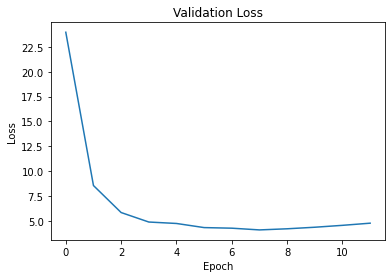

In [22]:
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show

In [11]:
# 학습된 모델을 테스트셋을 통해 확인.
# 다음은 학습된 모델의 가중치가 저장된 경로입니다.
# 위에서는 Early Stop으로 12 epoch에서 끝났지만 20 epochs 학습된 모델 불러와서 테스트.
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다.
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다.
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다.
# inference 전용 모델이에요.
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING


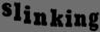

Result: 	 ALEPPO


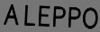

Result: 	 FWANDA


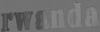

Result: 	 NATHANS


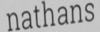

Result: 	 HALLE


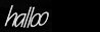

Result: 	 HURLS


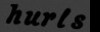

Result: 	 DOWNSIZE


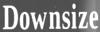

Result: 	 ROBOTIC


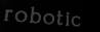

Result: 	 SLOPPY


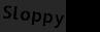

Result: 	 SHERMITE


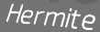

In [12]:
# 학습된 모델 성능 확인.
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다,
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다.
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(K.ctc_decode(out, input_length=np.ones(out.shape[0]) * out.shape[1],
                                      greedy=False, beam_width=5, top_paths=1)[0][0])[0]
    text = ""
    for index in indexes:
        if index == -1:  # 패딩 제거
            continue
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다.
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다.
def check_inference(model, dataset, index=5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1, :, :, :]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars='-' + TARGET_CHARACTERS)[0].replace('-', '')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1, 0, 2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

# End-to-End OCR

In [13]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [14]:
def detect_text(img_path):
    # TODO
    # 배치 크기를 위해서 dimension을 확장해주고 keras-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    # 비율유지하면서 축소.
    target_width = min(int(width * 300 / height), 400)
    target_img_size = (target_width, 300)
    
    img = img.resize(target_img_size)  # (400, 300, 3)
    img_pil = img.copy()
    img = np.expand_dims(np.array(img), axis=0)  # dimension 확장 (1, 300, 400, 3)
    
    # 배치의 첫 번째 결과만 가져옵니다.
    ocr_result = detector.detect(img)
    ocr_result = ocr_result[0]
    
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    img = np.squeeze(img, axis=0).astype(np.uint8)
    img = Image.fromarray(img)  # 
    img_draw = ImageDraw.Draw(img)
    
    
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return img_pil, cropped_imgs

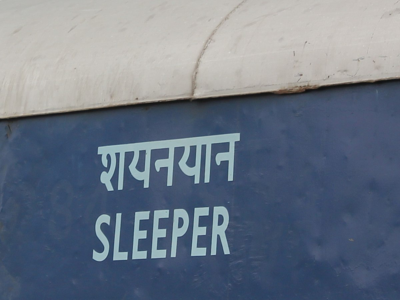

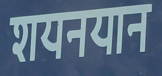

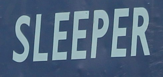

In [15]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)
for i in cropped_img:
    display(i)

In [16]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # 이미지 축소
    pil_img = pil_img.resize(input_img_size)  # (100, 32, 3)
    pil_img = np.expand_dims(np.array(pil_img).transpose(1, 0, 2), axis=0)
    
    output = model_pred.predict(pil_img)
    result = decode_predict_ctc(output, chars="-" + TARGET_CHARACTERS)[0].replace("-", "")
    print("Result: \t", result)
    display(Image.fromarray(pil_img[0].transpose(1, 0, 2).astype(np.uint8)))

Result: 	 SRUPRID


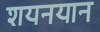

Result: 	 SLEEPER


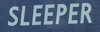

In [17]:
for _img in cropped_img:
    recognize_img(_img)

# 회고

* 본 과정에서는 CNN과 RNN을 섞은 CRNN 모델과 keras-ocr을 사용하여 OCR 결과를 확인해봅니다.
* 샘플이미지를 이용해서 테스트한 결과 영문이 잘 읽힘을 볼 수 있습니다.
* ocr을 하기위해 이미지의 다양한 형변환을 해보면서 많은 공부가되는 좋은 시간이었습니다.